In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import sys
sys.path.append("..")
sys.path.append("../src")
sys.path.append("../utils")
sys.path.append("../phantoms")
sys.path.append("../projections")
from src.algs import *
from src.projections import *
from src.phantoms import *


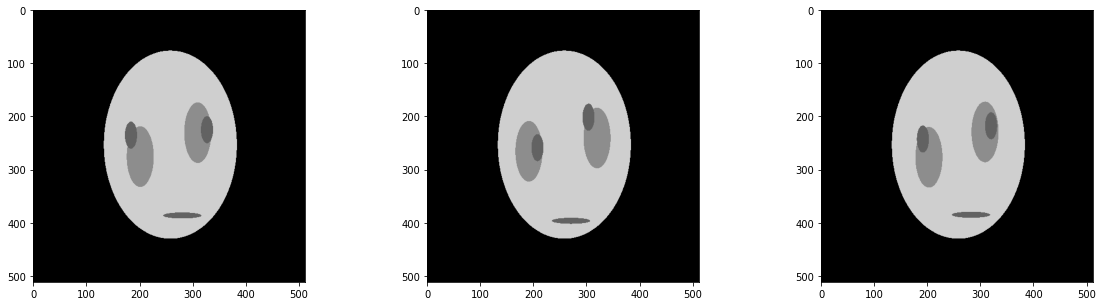

In [2]:
phantoms = create_phantoms("aliens", 512, n=3, overlap=True,
                                seed=0, img_name=None)
fig, ax = plt.subplots(1, len(phantoms), figsize=(20,5))
for i in range(len(phantoms)):
    ax[i].imshow(phantoms[i], cmap="Greys_r", vmin=0, vmax=255)

In [3]:
# ,easurement parameters
n_projections = 12
n_detectors = 512
det_spacing = 1
noise_factor = None
angles = np.linspace(0, np.pi*(120/180), n_projections)
# dart paramenters
dart_iters = 50
p = 1
rec_alg = 'SART_CUDA'
rec_iters = 1000
# compared algs iters
comp_iters = dart_iters * rec_iters

# open phantom
img = phantoms[0]
img_width, img_height = img.shape
gray_lvls = np.unique(img).astype(np.float16)
img_width, img_height = img.shape

# prepare all the data
img = np.array(Image.fromarray(img), dtype=np.uint8)
img_width, img_height = img.shape
gray_lvls = np.unique(img).astype(np.float16)
vol_geom = astra.creators.create_vol_geom([img_width,img_height])
phantom_id = astra.data2d.create('-vol', vol_geom, data=img)
# make measurements
projector_id, sino_id, sinogram = project_from_2D(phantom_id=phantom_id,
                                                vol_geom=vol_geom,
                                                n_projections=n_projections,
                                                n_detectors=n_detectors,
                                                detector_spacing=det_spacing,
                                                angles=angles,
                                                noise_factor=noise_factor,
                                                use_gpu=True)

proj_geom = astra.create_proj_geom('parallel', det_spacing, 
                                        n_detectors, angles)

# instanciate DART
dart = DART(gray_levels=gray_lvls, p=p, rec_shape=img.shape,
        proj_geom=proj_geom, projector_id=projector_id,
        sinogram=sinogram)

Mean absolute pixel error: 0.422771692276001


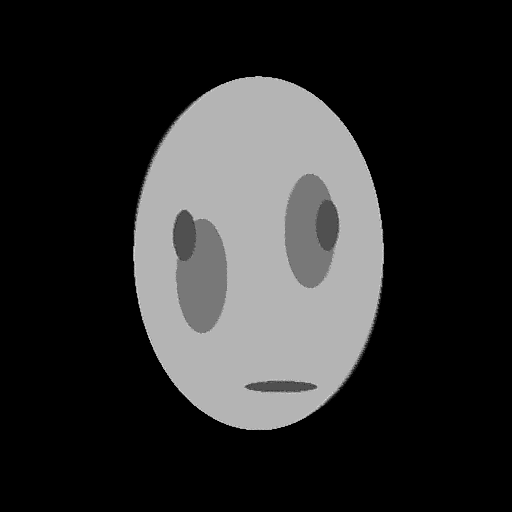

In [4]:
# run the algorithm
full_rec = dart.run(iters=dart_iters, rec_alg=rec_alg, rec_iter=rec_iters)
print(f"Mean absolute pixel error: {np.abs(img - full_rec).mean()}")
Image.fromarray(full_rec.astype(np.uint8))

Mean absolute pixel error: 2.8441238403320312


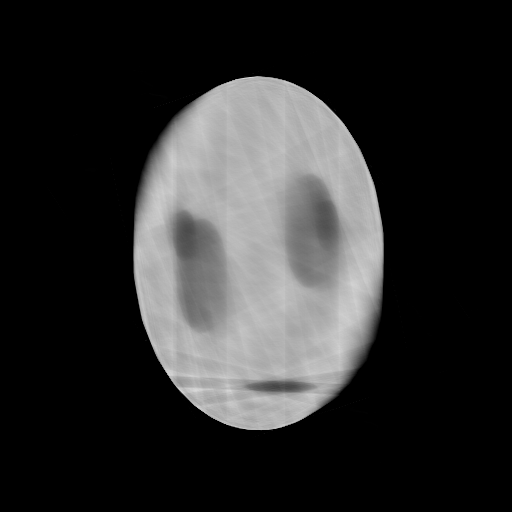

In [5]:
_, sart_res = SART(vol_geom,0,projector_id,sino_id,
                    iters=comp_iters, use_gpu=True)
print(f"Mean absolute pixel error: {np.abs(img - sart_res).mean()}")
Image.fromarray(sart_res.astype(np.uint8))

Mean absolute pixel error: 2.3643798828125


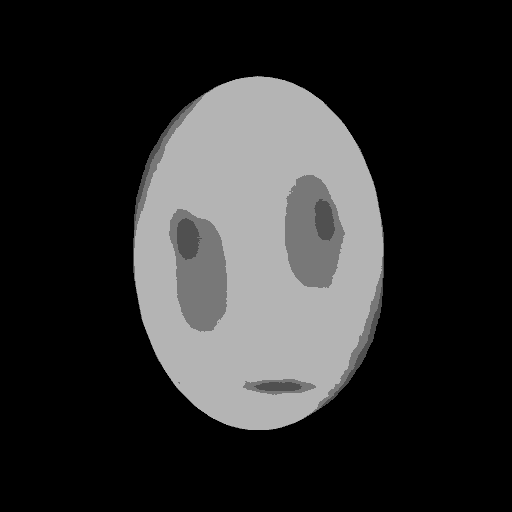

In [6]:
print(f"Mean absolute pixel error: {np.abs(img - Image.fromarray(dart.segment(sart_res))).mean()}")
Image.fromarray(dart.segment(sart_res))

Mean absolute pixel error: 2.8573591709136963


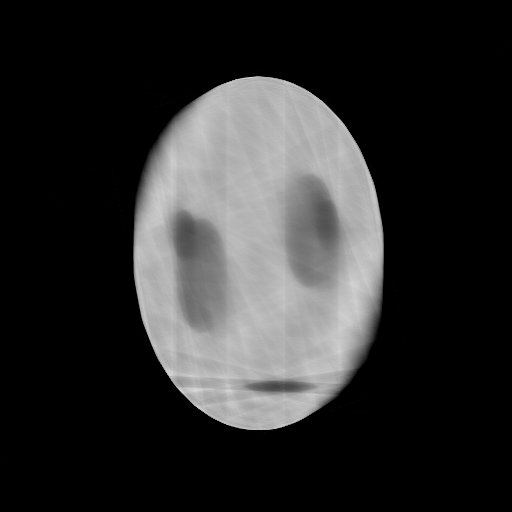

In [7]:
_, sirt_res = SIRT(vol_geom,0,sino_id,
                    iters=comp_iters, use_gpu=True)
print(f"Mean absolute pixel error: {np.abs(img - sirt_res).mean()}")
Image.fromarray(sirt_res.astype(np.uint8))

Mean absolute pixel error: 2.3805084228515625


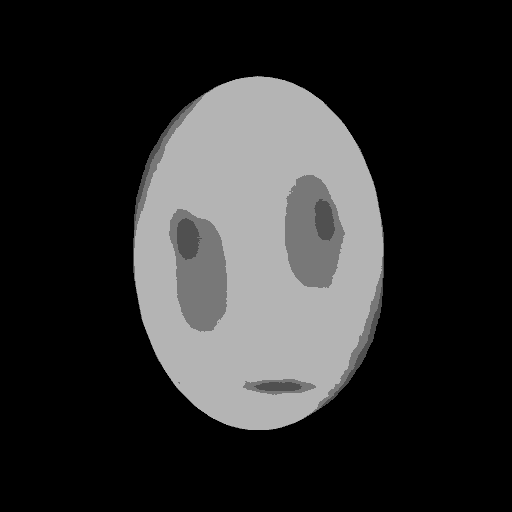

In [14]:
print(f"Mean absolute pixel error: {np.abs(img - Image.fromarray(dart.segment(sirt_res))).mean()}")
Image.fromarray(dart.segment(sart_res))

Mean absolute pixel error: 43.186405181884766


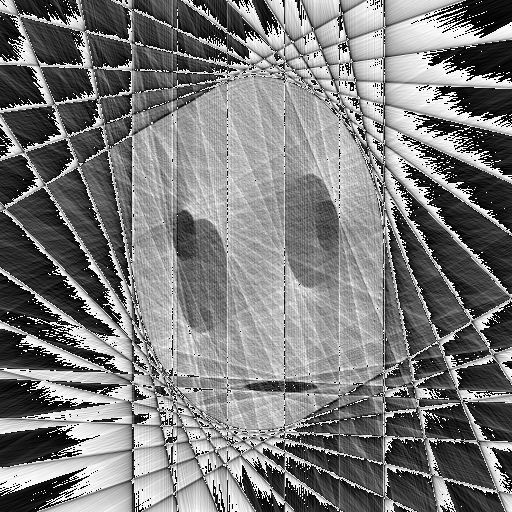

In [9]:
_, fbp_res = FBP(vol_geom,0,projector_id,sino_id,
                    iters=comp_iters, use_gpu=True)
print(f"Mean absolute pixel error: {np.abs(img - fbp_res).mean()}")
Image.fromarray(fbp_res.astype(np.uint8))

AxesSubplot(0.125,0.536818;0.227941x0.343182)
AxesSubplot(0.398529,0.536818;0.227941x0.343182)
AxesSubplot(0.672059,0.536818;0.227941x0.343182)
AxesSubplot(0.125,0.125;0.227941x0.343182)
AxesSubplot(0.398529,0.125;0.227941x0.343182)
AxesSubplot(0.672059,0.125;0.227941x0.343182)


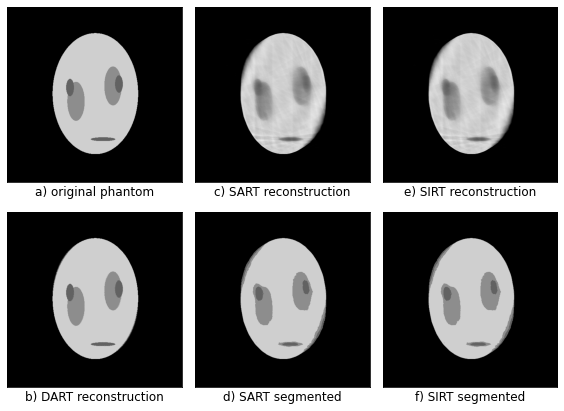

In [13]:
font = {'size'   : 12}
plt.rc('font', **font)

fig, ax = plt.subplots(2,3, figsize=(8,6))

ax[0,0].imshow(img, cmap="Greys_r", vmin=0, vmax=255)
ax[0,0].set_xlabel("a) original phantom")
ax[1,0].imshow(full_rec, cmap="Greys_r", vmin=0, vmax=255)
ax[1,0].set_xlabel("b) DART reconstruction")

ax[0,1].imshow(sart_res, cmap="Greys_r", vmin=0, vmax=255)
ax[0,1].set_xlabel("c) SART reconstruction")
ax[1,1].imshow(dart.segment(sart_res), cmap="Greys_r", vmin=0, vmax=255)
ax[1,1].set_xlabel("d) SART segmented")

ax[0,2].imshow(sirt_res, cmap="Greys_r", vmin=0, vmax=255)
ax[0,2].set_xlabel("e) SIRT reconstruction")
ax[1,2].imshow(dart.segment(sirt_res), cmap="Greys_r", vmin=0, vmax=255)
ax[1,2].set_xlabel("f) SIRT segmented")# remove ticks
for x in ax:
    for y in x:
        print(y)
        y.tick_params(left = False, bottom = False)
        y.set_xticks([])
        y.set_yticks([])
plt.tight_layout()
plt.show()